# Sklearn

## Bike Sharing Demand
Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодных условиях необходимо спрогнозировтаь спрос на прокат велосипедов.

В исходной постановке задачи доступно 11 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

Для демонстрации используется обучающая выборка из исходных данных train.csv, файлы для работы прилагаются.

### Библиотеки

In [35]:
from sklearn import model_selection, linear_model, metrics, pipeline, preprocessing

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

### Загрузка данных

In [3]:
raw_data = pd.read_csv('bike_sharing_demand.csv', header = 0, sep = ',')

In [4]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Предобработка данных

#### Обучение и отложенный тест

In [5]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [6]:
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)

In [7]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [90]:
print(raw_data.shape, train_data.shape, hold_out_test_data.shape)

(10886, 14) (9886, 14) (1000, 14)


In [8]:
#обучение
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [9]:
#тест
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

Почему так? Выглядит очень странно, мне кажется это можно сделать как нибудь по другому

In [10]:
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

In [11]:
print(binary_data_columns)
print(binary_data_indices)

['holiday', 'workingday']
[False  True  True False False False False False False False]


In [12]:
categorical_data_columns = ['season', 'weather', 'month'] 
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)

In [13]:
print(categorical_data_columns)
print(categorical_data_indices)

['season', 'weather', 'month']
[ True False False  True False False False False  True False]


In [14]:
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

In [15]:
print(numeric_data_columns)
print(numeric_data_indices)

['temp', 'atemp', 'humidity', 'windspeed', 'hour']
[False False False False  True  True  True  True False  True]


### Pipeline

In [16]:
regressor = linear_model.SGDRegressor(random_state = 0, loss = 'squared_loss', penalty = 'l2')

In [17]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
#               добавил кубические признаки, результат немного улучшился
                ('polynom_f', preprocessing.PolynomialFeatures(3)),
                ('scaling', preprocessing.StandardScaler(with_mean = 0))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [18]:
estimator.fit(train_data, train_labels)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x114279730>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          valida...,
       power_t=0.25, random_state=0, shuffle=True, tol=None, verbose=0,
       warm_start=False))])

In [19]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

103.86555460049428

### Подбор параметров

In [121]:
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'feature_processing', 'model_fitting', 'feature_processing__n_jobs', 'feature_processing__transformer_list', 'feature_processing__transformer_weights', 'feature_processing__binary_variables_processing', 'feature_processing__numeric_variables_processing', 'feature_processing__categorical_variables_processing', 'feature_processing__binary_variables_processing__accept_sparse', 'feature_processing__binary_variables_processing__func', 'feature_processing__binary_variables_processing__inv_kw_args', 'feature_processing__binary_variables_processing__inverse_func', 'feature_processing__binary_variables_processing__kw_args', 'feature_processing__binary_variables_processing__pass_y', 'feature_processing__binary_variables_processing__validate', 'feature_processing__numeric_variables_processing__memory', 'feature_processing__numeric_variables_processing__steps', 'feature_processing__numeric_variables_processing__selecting', 'feature_processing__numeric_variables_proces

In [20]:
parameters_grid = {
    'model_fitting__alpha' : [0.0001, 0.001, 0,1],
    'model_fitting__eta0' : [0.001, 0.05],
}

In [27]:
grid_cv = model_selection.GridSearchCV(estimator, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 4)

In [28]:
%%time
grid_cv.fit(train_data, train_labels);

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 

CPU times: user 5.18 s, sys: 1.1 s, total: 6.28 s
Wall time: 6.78 s


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 

GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x114279730>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          valida...,
       power_t=0.25, random_state=0, shuffle=True, tol=None, verbose=0,
       warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model_fitting__alpha': [0.0001, 0.001, 0, 1], 'model_fitting__eta0': [0.001, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [29]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-106.73245594546157
{'model_fitting__alpha': 0, 'model_fitting__eta0': 0.001}


### Оценка по отложенному тесту

In [30]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [31]:
metrics.mean_absolute_error(test_labels, test_predictions)

112.32968377730332

In [32]:
print(test_labels[:20])

[525 835 355 222 228 325 328 308 346 446 943 838 531 432 195 181 199  49
  17  16]


In [33]:
print(test_predictions[:20])

[187.02178959 202.77681557 249.220972   277.23156336 293.73122482
 311.82635854 316.28986244 334.96210622 345.00613377 346.97844027
 327.42523396 309.14247082 261.71009147 238.08084106 218.55939115
 177.09930114 150.22453487  68.24664899  83.95633146  98.97236632]


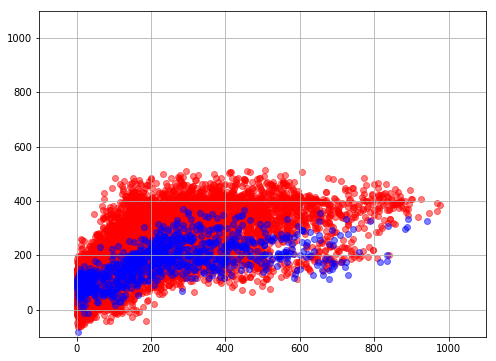

In [37]:
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.xlim(-100,1100)
plt.ylim(-100,1100)
plt.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
plt.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')

### Другая модель

In [38]:
from sklearn.ensemble import RandomForestRegressor

In [39]:
regressor = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 50)

In [40]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [41]:
estimator.fit(train_data, train_labels)

Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x11521d840>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          valida..._estimators=50, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [43]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

79.47728153978812

In [44]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446])

In [45]:
estimator.predict(test_data)[:10]

array([409.565     , 505.56      , 256.06066667, 165.6502619 ,
       205.82474784, 265.91960439, 254.49615818, 317.85774486,
       280.98963263, 441.59333333])

Text(0.5,1,'random forest model')

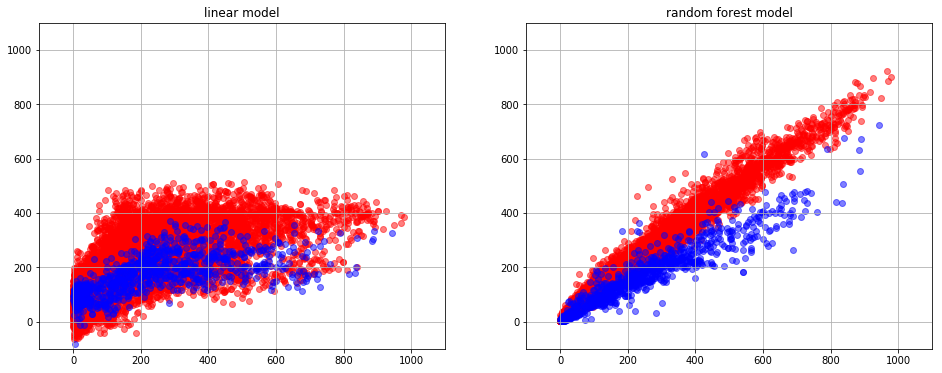

In [138]:
put.figure(figsize=(16, 6))

put.subplot(1,2,1)
put.grid(True)
put.xlim(-100,1100)
put.ylim(-100,1100)
put.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
put.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
put.title('linear model')

put.subplot(1,2,2)
put.grid(True)
put.xlim(-100,1100)
put.ylim(-100,1100)
put.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color = 'red')
put.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color = 'blue')
put.title('random forest model')